# the model

In [2]:
import duckdb
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

## get the data & encode

In [3]:
table = "sandbox_T_apartment_S_ga_fl_preprocessed"

In [4]:
con = duckdb.connect('data/exploitation.db', read_only=True)
df = con.execute(f"select * from {table}").df()
df.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,...,preschool,elementary_school,middle_school,high_school,N_baths,half_baths,b_hospital_type_critical,b_hospital_type_longterm,b_hospital_type_children,b_type
0,jacksonville,6.659294,apartment,6.444131,1.0,1.0,Yes,Yes,No,No,...,9.307195,7.957527,7.933438,7.830823,1.0,No,No,No,Yes,Apartment
1,jacksonville,7.446001,apartment,7.227662,3.0,2.0,Yes,Yes,Yes,Yes,...,9.403272,8.055158,8.096817,7.918629,2.0,No,No,Yes,Yes,Apartment
2,jacksonville,7.086738,apartment,6.775366,1.0,1.0,Yes,Yes,Yes,No,...,9.403272,8.055158,8.096817,7.918629,1.0,No,No,Yes,Yes,Apartment
3,jacksonville,6.594413,apartment,6.685861,3.0,1.0,Yes,Yes,No,No,...,8.168770,6.806829,6.806829,6.511745,1.0,No,No,No,Yes,Apartment
4,jacksonville,6.728629,apartment,6.763885,2.0,1.0,Yes,Yes,No,No,...,8.331105,7.003974,7.048386,6.716595,1.0,No,No,No,Yes,Apartment


In [7]:
df.loc[1:5, df.columns[0:20]]

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state,num_hospitals,num_beds,hospital_type_general
1,jacksonville,7.446001,apartment,7.227662,3.0,2.0,Yes,Yes,Yes,Yes,No,No,w/d in unit,detached garage,30.2214,-81.5571,fl,1340.0,12.690811,6.844815
2,jacksonville,7.086738,apartment,6.775366,1.0,1.0,Yes,Yes,Yes,No,No,No,w/d in unit,detached garage,30.2214,-81.5571,fl,1340.0,12.690811,6.844815
3,jacksonville,6.594413,apartment,6.685861,3.0,1.0,Yes,Yes,No,No,No,No,unknow,unknow,30.3894,-81.7219,fl,378.0,11.441139,5.613128
4,jacksonville,6.728629,apartment,6.763885,2.0,1.0,Yes,Yes,No,No,No,No,laundry on site,off-street parking,30.3480,-81.5882,fl,400.0,11.585488,5.620401
5,jacksonville,6.529419,apartment,6.171701,0.0,1.0,Yes,Yes,Yes,No,No,No,unknow,off-street parking,30.2787,-81.5831,fl,399.0,11.525476,5.613128


In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [9]:
# select columns
y_col = 'price'
exclude_cols = ['region']
x_cols_onehot = ['type', 'state', 'laundry_options', 'parking_options']
x_cols_binary = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'half_baths'] + [
    c for c in df.columns if c[0:2]=='b_'
]
x_cols_numeric = [c for c in df.columns if not c in [y_col] + exclude_cols + x_cols_onehot + x_cols_binary]

In [10]:
# make everything numeric and scaled
bin2num = lambda x: 1 if x=='Yes' or x==1 or x=="Apartment" else 0
for col in x_cols_binary:
    df[col] = df[col].apply(bin2num)

# one-hot encoding in categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[x_cols_onehot])

cols_encoded = []
for i in range(len(x_cols_onehot)):
  col = x_cols_onehot[i]
  print("col: ", col)
  for name in enc.categories_[i]:
    cols_encoded.append(str(col+'_'+name[0:].strip()).lower().strip())
    print("name: ", str(col+'_'+name[0:].strip()).lower().strip())

df_onehot_encoded = pd.DataFrame(enc.transform(df[x_cols_onehot]).toarray(), columns = cols_encoded)

# scaling numerical variables:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[x_cols_numeric]), columns = x_cols_numeric)



col:  type
name:  type_apartment
col:  state
name:  state_fl
name:  state_ga
col:  laundry_options
name:  laundry_options_laundry in bldg
name:  laundry_options_laundry on site
name:  laundry_options_no laundry on site
name:  laundry_options_unknow
name:  laundry_options_w/d hookups
name:  laundry_options_w/d in unit
col:  parking_options
name:  parking_options_attached garage
name:  parking_options_carport
name:  parking_options_detached garage
name:  parking_options_no parking
name:  parking_options_off-street parking
name:  parking_options_street parking
name:  parking_options_unknow
name:  parking_options_valet parking


In [11]:
# columns in the one-hot encoding
print(enc.feature_names_in_)
print(enc.categories_)

# parameters used in the scaling
print(scaler.feature_names_in_)
print(scaler.mean_)
print(scaler.scale_)

['type' 'state' 'laundry_options' 'parking_options']
[array(['apartment'], dtype=object), array(['fl', 'ga'], dtype=object), array(['laundry in bldg', 'laundry on site', 'no laundry on site',
       'unknow', 'w/d hookups', 'w/d in unit'], dtype=object), array(['attached garage', 'carport', 'detached garage', 'no parking',
       'off-street parking', 'street parking', 'unknow', 'valet parking'],
      dtype=object)]
['sqfeet' 'beds' 'baths' 'lat' 'long' 'num_hospitals' 'num_beds'
 'hospital_type_general' 'hospital_type_critical'
 'hospital_type_psychiatric' 'hospital_type_longterm'
 'hospital_type_children' 'government_hospital' 'nonprofit_hospital'
 'private_hospital' 'num_schools' 'num_students' 'preschool'
 'elementary_school' 'middle_school' 'high_school' 'N_baths']
[ 6.84388707e+00  1.80208977e+00  1.54532251e+00  3.00822571e+01
 -8.26397952e+01  1.88424541e+03  1.19386020e+01  6.20586698e+00
  8.03420703e-01  4.65106871e+00  3.48562208e+00  1.21399836e+00
  4.41349698e+00  5.311

In [12]:
# dataset with encoding columns to numeric
df_encoded = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df[x_cols_numeric], df[[y_col]]
], axis = 1
)

# dataset with encoding + scaling
df_scaled = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df_scaled, df[[y_col]]
], axis = 1
)

#df_processed.fillna(0, inplace=True)
#df_processed.head()

In [117]:
# split training set and test set and validation set
df_train, df_val, df_test = np.split(
    df_encoded.sample(frac=1, random_state=777),
    [ int(0.6*len(df_encoded)) , int(0.8*len(df_encoded)) ]
    )

df_train2, df_val2, df_test2 = np.split(
    df_scaled.sample(frac=1, random_state=777),
    [ int(0.6*len(df_scaled)) , int(0.8*len(df_scaled)) ]
    )

X_train = df_train.drop(y_col, axis=1)
y_train = df_train[y_col]
X_val = df_val.drop(y_col, axis=1)
y_val = df_val[y_col]
X_test = df_test.drop(y_col, axis=1)
y_test = df_test[y_col]

## model training

In [14]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [15]:
def printMetrics(y_true, y_pred):
    print("RMSE: ", round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))
    print("MAE: ", round(metrics.mean_absolute_error(y_true, y_pred),4))
    print("MAPE: ", round(metrics.mean_absolute_percentage_error(y_true, y_pred),4))
    print("R2: ", round(metrics.r2_score(y_true, y_pred),4))

### option 1-1 - linear regression (without regularization)

In [16]:
reg = LinearRegression().fit(X_train, y_train)
yhat_train_lin = reg.predict(X_train)
yhat_val_lin = reg.predict(X_val)

In [17]:
printMetrics(y_train, yhat_train_lin)
print()
printMetrics(y_val, yhat_val_lin)

RMSE:  0.2109
MAE:  0.1575
MAPE:  0.0227
R2:  0.5413

RMSE:  0.2143
MAE:  0.1596
MAPE:  0.0231
R2:  0.5401


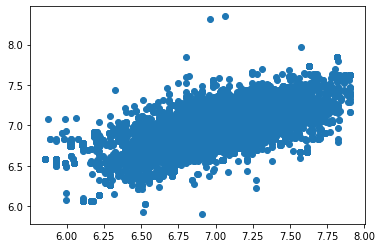

In [18]:
plt.scatter(y_train, yhat_train_lin)

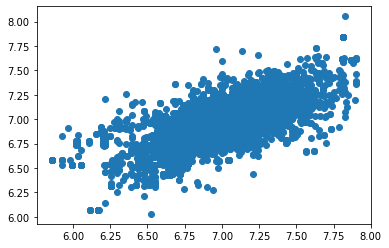

In [19]:
plt.scatter(y_val, yhat_val_lin)

### option 1-2 - ridge regression
it uses leave-one-out cross-validation to tune the regularization parameter

In [20]:
rreg = RidgeCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

In [21]:
rreg.score(X_train, y_train)

0.5415217054237922

In [22]:
yhat_train_rr = rreg.predict(X_train)
yhat_val_rr = rreg.predict(X_val)

In [23]:
rreg.get_params()

{'alpha_per_target': False,
 'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': 'deprecated',
 'scoring': None,
 'store_cv_values': False}

In [24]:
rreg.alpha_

0.1

In [25]:
printMetrics(y_train, yhat_train_rr)
print()
printMetrics(y_val, yhat_val_rr)

RMSE:  0.2109
MAE:  0.1574
MAPE:  0.0227
R2:  0.5415

RMSE:  0.2142
MAE:  0.1596
MAPE:  0.0231
R2:  0.5406


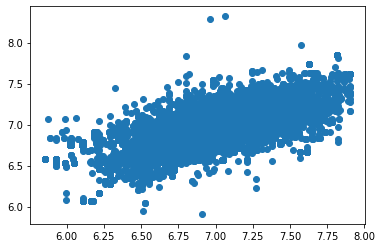

In [26]:
plt.scatter(y_train, yhat_train_rr)

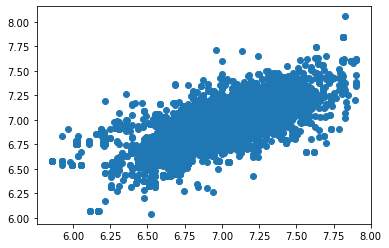

In [27]:
plt.scatter(y_val, yhat_val_rr)

### option 1-3 - lasso regression

In [28]:
lreg = LassoCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2572218405367721, tolerance: 0.17585241576653363
  model = cd_fast.enet_coordinate_descent_gram(


In [29]:
lreg.score(X_train, y_train)

0.5253812585032518

In [30]:
yhat_train_lr = lreg.predict(X_train)
yhat_val_lr = lreg.predict(X_val)

In [31]:
lreg.get_params()

{'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [32]:
lreg.alpha_

0.001

In [33]:
printMetrics(y_train, yhat_train_lr)
print()
printMetrics(y_val, yhat_val_lr)

RMSE:  0.2146
MAE:  0.1602
MAPE:  0.0231
R2:  0.5254

RMSE:  0.2178
MAE:  0.1623
MAPE:  0.0235
R2:  0.5251


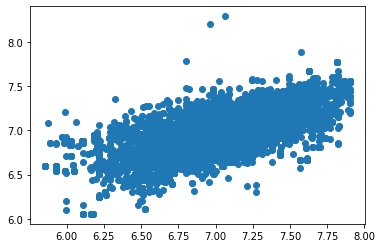

In [34]:
plt.scatter(y_train, yhat_train_lr)

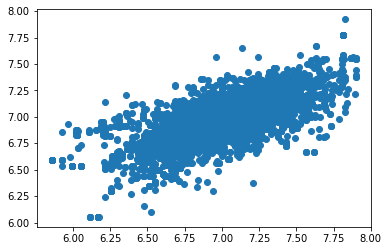

In [35]:
plt.scatter(y_val, yhat_val_lr)

### option 2 - random forest
random forest from scikit-learn library, with the default parameters

In [36]:
rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)

In [39]:
yhat_train_rf = rf.predict(X_train)
yhat_val_rf = rf.predict(X_val)

In [40]:
printMetrics(y_train, yhat_train_rf)
print()
printMetrics(y_val, yhat_val_rf)

RMSE:  0.0437
MAE:  0.0229
MAPE:  0.0033
R2:  0.9803

RMSE:  0.0832
MAE:  0.0388
MAPE:  0.0055
R2:  0.9307


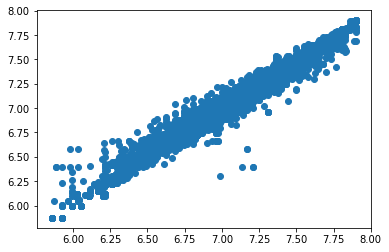

In [41]:
plt.scatter(y_train, yhat_train_rf)

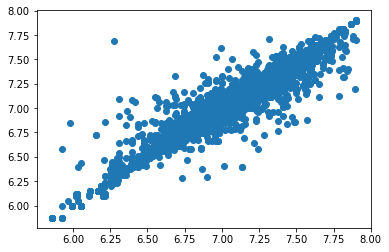

In [42]:
plt.scatter(y_val, yhat_val_rf)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

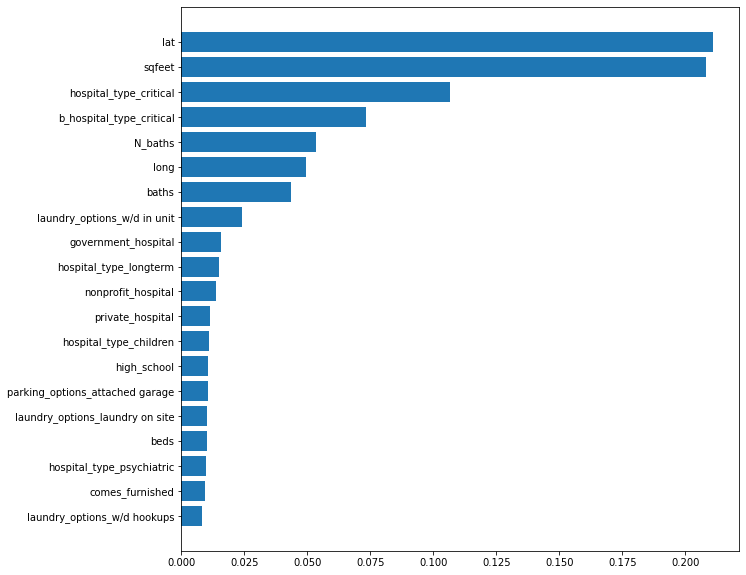

In [120]:
# top 20 feature importance
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(rf.feature_names_in_[sorted_idx][-20:], rf.feature_importances_[sorted_idx][-20:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [76]:
from sklearn.tree import plot_tree

[Text(0.5, 0.875, 'hospital_type_critical <= -0.238\nsquared_error = 0.096\nsamples = 14395\nvalue = 6.961'),
 Text(0.25, 0.625, 'lat <= -1.139\nsquared_error = 0.077\nsamples = 11974\nvalue = 7.018'),
 Text(0.125, 0.375, 'lat <= -1.685\nsquared_error = 0.063\nsamples = 1719\nvalue = 7.259'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'sqfeet <= 0.105\nsquared_error = 0.069\nsamples = 10255\nvalue = 6.978'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'lat <= 1.355\nsquared_error = 0.088\nsamples = 2421\nvalue = 6.674'),
 Text(0.625, 0.375, 'sqfeet <= -0.671\nsquared_error = 0.071\nsamples = 1566\nvalue = 6.56'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'baths <= 0.343\nsquared_error = 0.053\nsamples = 855\nvalue = 6.882'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

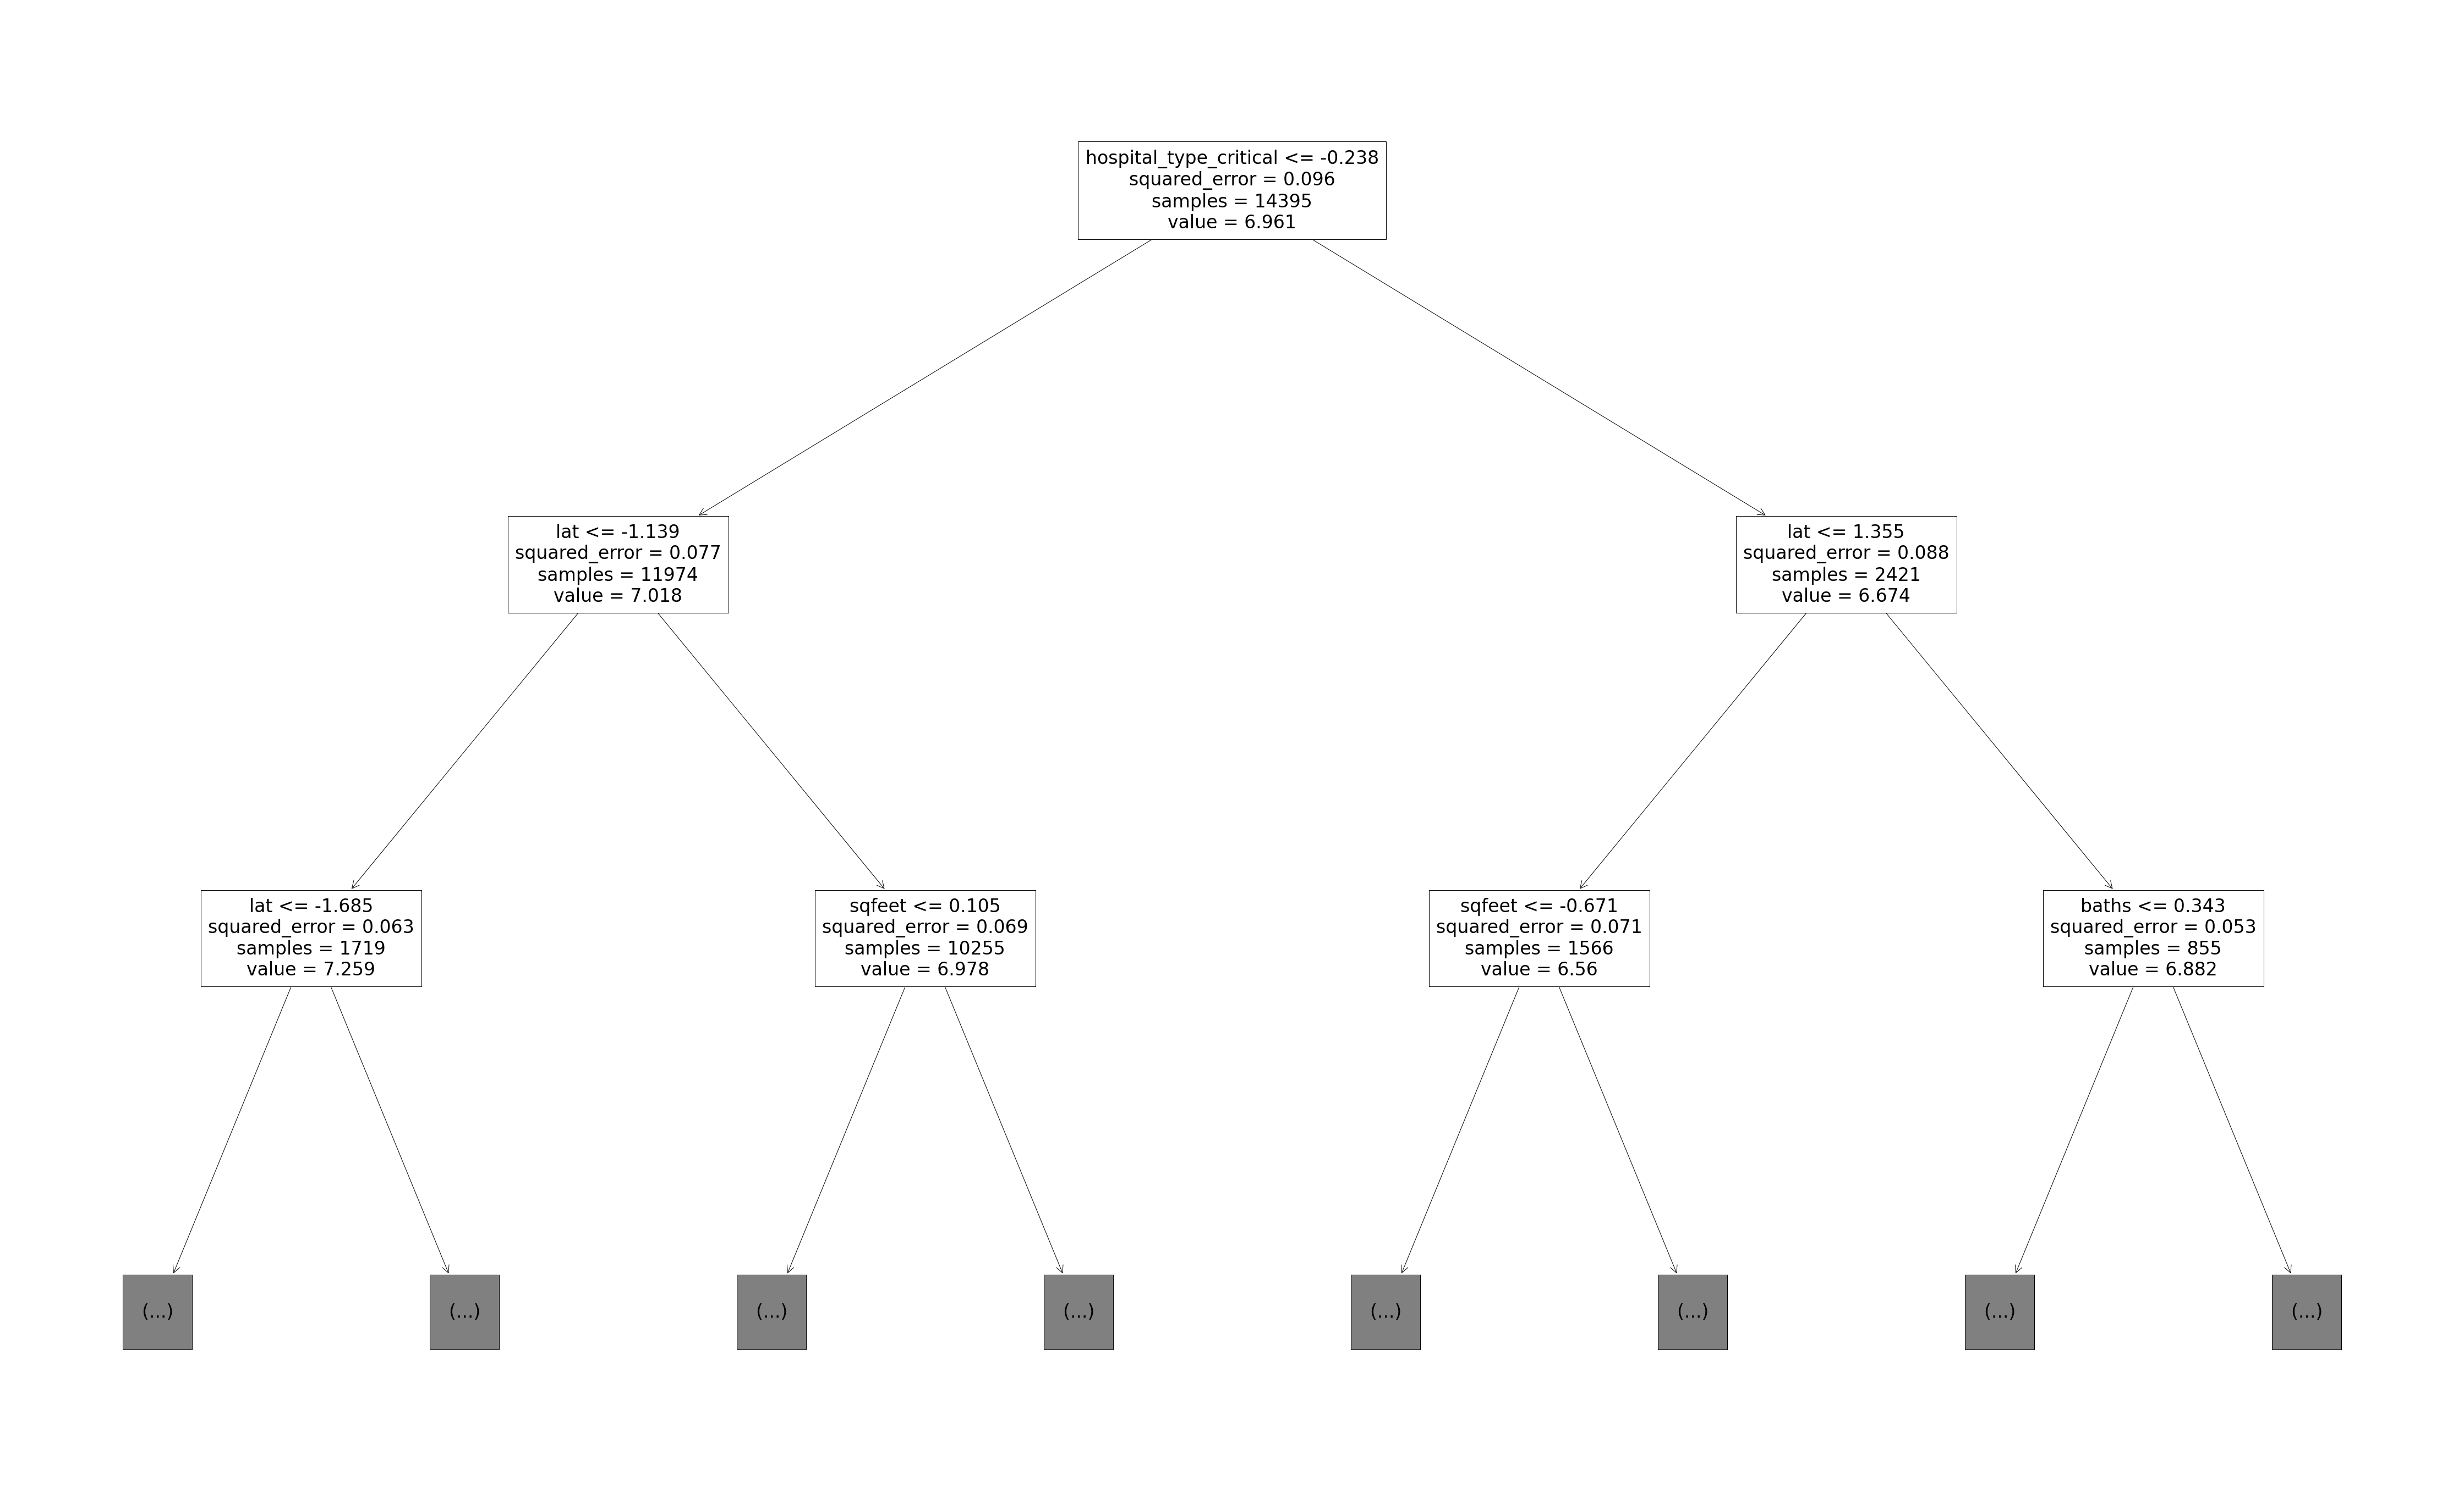

In [85]:
# plot of one of the trees of the random forest
# cut at 2 levels, for visualization
plot_tree(rf.estimators_[0], max_depth=2, feature_names=rf.feature_names_in_)

### option 3 - xgboost

#### without hyperparameter tunning

In [43]:
#!pip install -U xgboost --quiet

In [44]:
import xgboost as xgb

In [45]:
param = {
    'objective':'reg:squarederror',
    'verbosity':1,
    'learning_rate':0.3,
    'max_depth':10,
    'subsample':0.8, # to avoid overfitting
    'reg_lambda':0.1, # L2 reg
    'alpha':0, #L1 reg
    'max_leaves':10
}
n_estim = 20

In [46]:
data_train = xgb.DMatrix(X_train, label=y_train)
data_val = xgb.DMatrix(X_val, label=y_val)

In [47]:
time0 = time()
xgb_1 = xgb.train(param, data_train, n_estim)
print(time()-time0)

0.17955279350280762


In [48]:
yhat_train_xgb1 = xgb_1.predict(data_train)
yhat_val_xgb1 = xgb_1.predict(data_val)

In [49]:
printMetrics(y_train, yhat_train_xgb1)
print()
printMetrics(y_val, yhat_val_xgb1)

RMSE:  1.1038
MAE:  1.0872
MAPE:  0.1554
R2:  -11.561

RMSE:  1.1034
MAE:  1.086
MAPE:  0.1553
R2:  -11.1928


In [54]:
from xgboost import plot_importance, plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

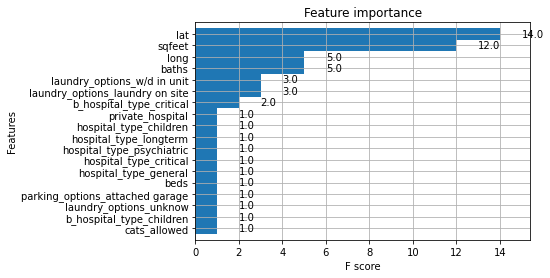

In [55]:
plot_importance(xgb_1, max_num_features = 30, height = 1)

In [68]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

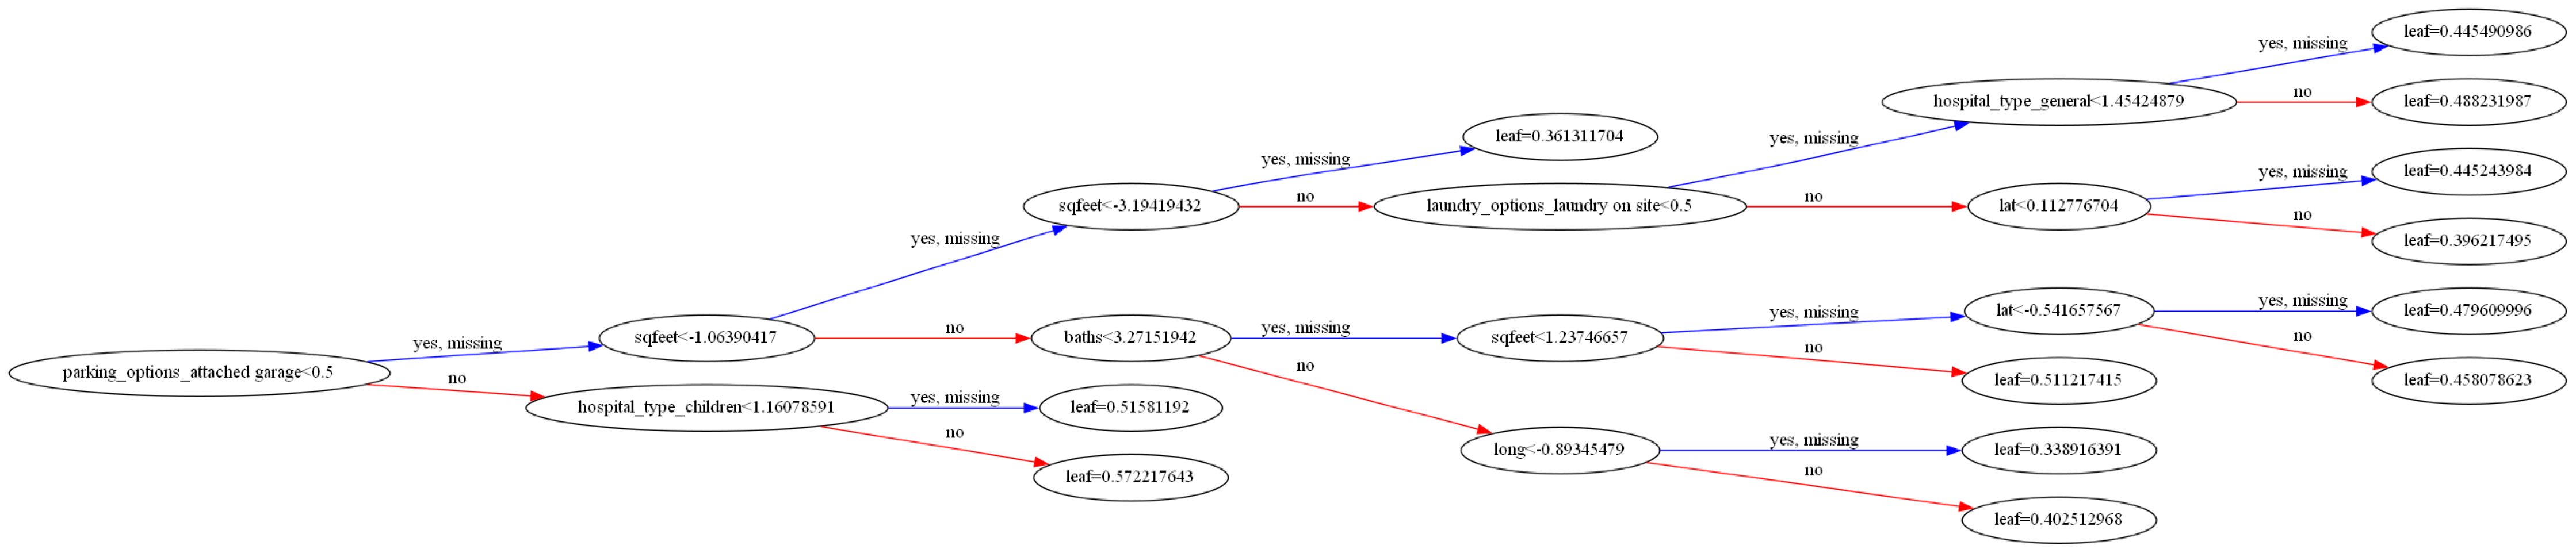

In [69]:
plt.figure(figsize=(10,10))
xgb.plot_tree(xgb_1, num_trees = 4, rankdir="LR")

In [57]:
# if the previous cell (plot_tree) doesn't work, install graphviz from here and add it to the path:

#https://graphviz.org/download/
#import os
#os.environ["PATH"] += os.pathsep+'C:/Program Files (x86)/Graphviz/bin'

#### with hyperparameter tunning

In [150]:
from sklearn.model_selection import GridSearchCV

In [151]:
params = {
    #'objective':'reg:squarederror',
    #'verbosity':1,
    'learning_rate':[0.1, 0.3, 1],
    'max_depth':[5, 7, 10],
    'subsample':[0.8], # to avoid overfitting
    'reg_lambda':[0, 0.1, 1], # L2 reg
    'alpha':[0, 0.1, 1], #L1 reg
    'max_leaves':[10],
    'n_estimators':[5, 10, 20]
}


In [152]:
xgbr = xgb.XGBRegressor(seed = 20, objective = 'reg:squarederror', verbosity = 1)

time0 = time()
xgb_grid = GridSearchCV(estimator=xgbr, param_grid = params, cv = 3)
xgb_grid.fit(X_train, y_train)
# retrain with the best parameters:
xgb_cv = xgb.train(xgb_grid.best_params_, data_train, xgb_grid.best_params_['n_estimators'])

print(time()-time0) # time ~ 443s

[00:30:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

310.11668252944946


In [153]:
"""{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0,
 'subsample': 0.8}"""
xgb_grid.best_params_

{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0,
 'subsample': 0.8}

In [154]:
yhat_train_xgbcv = xgb_grid.predict(X_train)
yhat_val_xgbcv = xgb_grid.predict(X_val)

In [155]:
printMetrics(y_train, yhat_train_xgbcv)
print("")
printMetrics(y_val, yhat_val_xgbcv)

RMSE:  0.0564
MAE:  0.0373
MAPE:  0.0053
R2:  0.9672

RMSE:  0.0896
MAE:  0.0501
MAPE:  0.0072
R2:  0.9196


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

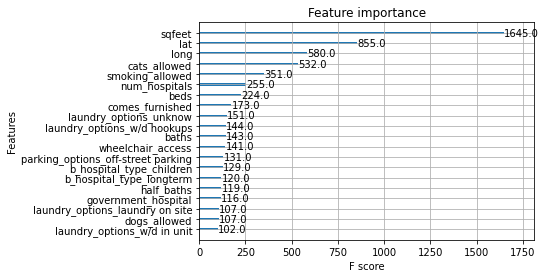

In [156]:
plot_importance(xgb_cv, max_num_features=20)

### 4 - SVR

triga molt més que els altres i no dona millors resultats

In [111]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
svr = SVR(C=1, epsilon=0.2)
svr.fit(X_train, y_train)

SVR(C=1, epsilon=0.2)

In [112]:
svr.get_params()

{'C': 1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [113]:
yhat_train_svr = svr.predict(X_train)
yhat_val_svr = svr.predict(X_val)

In [103]:
printMetrics(y_train, yhat_train_svr)
print("")
printMetrics(y_val, yhat_val_svr)

RMSE:  0.1361
MAE:  0.1098
MAPE:  0.0158
R2:  0.8089

RMSE:  0.1434
MAE:  0.1128
MAPE:  0.0162
R2:  0.7941


tunning parameters

In [108]:
from sklearn.model_selection import GridSearchCV

In [110]:
grid_svr = {
    'C':[1,10,100],
    'epsilon':[0.05,0.1,0.2,0.5]
}
grid_search_svr = GridSearchCV(SVR(), grid_svr)
grid_search_svr.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 10, 100], 'epsilon': [0.05, 0.1, 0.2, 0.5]})

# plots

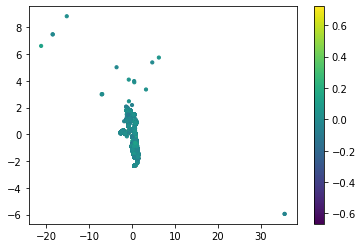

In [157]:
plt.scatter(X_train.long, X_train.lat, c=y_train-yhat_train_xgbcv, s=10)
plt.colorbar()

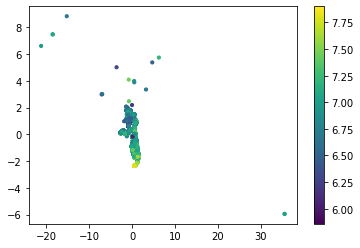

In [158]:
plt.scatter(X_train.long, X_train.lat, c=y_train, s=10)
plt.colorbar()